#### Confounding variable analysis

In [148]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import scipy
import pandas as pd
import os
from scipy import stats
from IPython.display import display, HTML

In [149]:
folder = '/root/capsule/data/filtered_data_session/filtered_data_101724.csv' # Updated** as of 10/17/24
main_df = pd.read_csv(folder)

/tmp/ipykernel_1412/3852814485.py:2: DtypeWarning: Columns (6,7,8,26,27,28,29,30,146,147,148,149,150,151,152,153,154,155,156,157,158) have mixed types. Specify dtype option on import or set low_memory=False.
  main_df = pd.read_csv(folder)


In [150]:
# Let's look at individual trainer foraging performance scores first 
df = main_df[['subject_id', 'user_name', 'foraging_performance', 'session_date', 'curriculum_name']]

# Convert session_date to dates 
df['session_date'] = pd.to_datetime(df['session_date'])
df = df.sort_values(by=['subject_id', 'session_date'])

# Curriculum filter
#df = df[df['curriculum_name'].isin(['Uncoupled Baiting'])]

# User filter 
user = 'Henry Loeffler'
select_df = df[df['user_name'] == user]

df

/tmp/ipykernel_1412/4273950631.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['session_date'] = pd.to_datetime(df['session_date'])


,subject_id,user_name,foraging_performance,session_date,curriculum_name
4596,662914,Katrina Nguyen,0.63,2023-09-19,NaN
4591,662914,Katrina Nguyen,0.78,2023-09-21,NaN
4581,662914,Katrina Nguyen,0.83,2023-09-22,NaN
4576,662914,Katrina Nguyen,0.66,2023-09-25,NaN
4558,662914,Katrina Nguyen,0.78,2023-09-29,NaN
...,...,...,...,...,...
19,757129,Henry Loeffler,0.77,2024-10-16,Uncoupled Without Baiting
37,764769,Avalon Amaya,0.63,2024-10-15,Uncoupled Baiting
10,764769,Avalon Amaya,0.75,2024-10-16,Uncoupled Baiting
39,764787,Avalon Amaya,0.21,2024-10-15,Uncoupled Baiting


In [151]:
def identify_multiple_trainers(df):
    """ 
    Finds subjects with multiple users

    Input: df with 'user_name' and 'subject_id'
    Output: df with 'subject_id', 'multiple_trainers' (boolean), 'trainer_count', 'trainer_list'
    """ 

    # Count unique users per subject
    trainer_analysis = (df.groupby('subject_id')
                            .agg({'user_name': lambda x: [len(set(x)), list(set(x))]
                            })
                            .reset_index())

    trainer_analysis[['trainer_count', 'trainer_list']] = pd.DataFrame(
                    trainer_analysis['user_name'].tolist(), index=trainer_analysis.index
    )

    result_df = pd.DataFrame({
        'subject_id': trainer_analysis['subject_id'],
        'multiple_trainers': trainer_analysis['trainer_count'] > 1,
        'trainer_count': trainer_analysis['trainer_count'],
        'trainer_list': trainer_analysis['trainer_list']
    })

    return result_df

In [152]:
multiple_trainers_df = identify_multiple_trainers(df)

multiple_trainers_df

,subject_id,multiple_trainers,trainer_count,trainer_list
0,662914,True,2,"[Katrina Nguyen, Ella Hilton]"
1,663612,False,1,[Katrina Nguyen]
2,668463,True,2,"[Travis Ramirez, Lucas Kinsey]"
3,668546,True,2,"[Katrina Nguyen, Ella Hilton]"
4,668548,False,1,[Katrina Nguyen]
...,...,...,...,...
214,754375,False,1,[Avalon Amaya]
215,757128,True,2,"[Ella Hilton, margaret lee]"
216,757129,False,1,[Henry Loeffler]
217,764769,False,1,[Avalon Amaya]


In [176]:
consistency_results = calculate_training_consistency(select_df)
#display(HTML(consistency_results.to_html()))

consistency_results = consistency_results.merge(
    multiple_trainers_df[['subject_id', 'multiple_trainers']], on='subject_id', how='left'
)


consistency_results

KeyError: 'session_date'

In [154]:
# Training Consistency df

# Group by subject_id and user_name 
consistency_df = df.groupby(['subject_id', 'user_name']).agg({
    'session_date': lambda x: (x.max() - x.min()).days + 1,  # Total date range in days
    'foraging_performance': 'count'  # Number of training days
}).reset_index()

# Rename columns
consistency_df.columns = ['subject_id', 'user_name', 'date_range', 'training_days']

# Calculate consistency (# trained sessions/total date range)
consistency_df['training_consistency'] = consistency_df['training_days'] / consistency_df['date_range']

foraging_peformance_df = df.groupby(['subject_id', 'user_name'])['foraging_performance'].mean().reset_index()
consistency_df = consistency_df.merge(foraging_peformance_df, on=['subject_id', 'user_name'], how='left')

consistency_df

,subject_id,user_name,date_range,training_days,training_consistency,foraging_performance
0,662914,Ella Hilton,4,4,1.00,0.83
1,662914,Katrina Nguyen,11,5,0.45,0.74
2,663612,Katrina Nguyen,11,5,0.45,0.55
3,668463,Lucas Kinsey,50,23,0.46,0.61
4,668463,Travis Ramirez,5,3,0.60,0.51
...,...,...,...,...,...,...
365,757128,Ella Hilton,26,17,0.65,0.61
366,757128,margaret lee,3,2,0.67,0.79
367,757129,Henry Loeffler,31,20,0.65,0.61
368,764769,Avalon Amaya,2,2,1.00,0.69


In [155]:
consistency_df = consistency_df.merge(
    multiple_trainers_df[['subject_id', 'multiple_trainers']], on='subject_id', how='left'
)

consistency_df

,subject_id,user_name,date_range,training_days,training_consistency,foraging_performance,multiple_trainers
0,662914,Ella Hilton,4,4,1.00,0.83,True
1,662914,Katrina Nguyen,11,5,0.45,0.74,True
2,663612,Katrina Nguyen,11,5,0.45,0.55,False
3,668463,Lucas Kinsey,50,23,0.46,0.61,True
4,668463,Travis Ramirez,5,3,0.60,0.51,True
...,...,...,...,...,...,...,...
365,757128,Ella Hilton,26,17,0.65,0.61,True
366,757128,margaret lee,3,2,0.67,0.79,True
367,757129,Henry Loeffler,31,20,0.65,0.61,False
368,764769,Avalon Amaya,2,2,1.00,0.69,False


In [156]:
plt.rcParams['image.cmap'] = 'viridis'

<Axes: xlabel='foraging_performance', ylabel='training_consistency'>

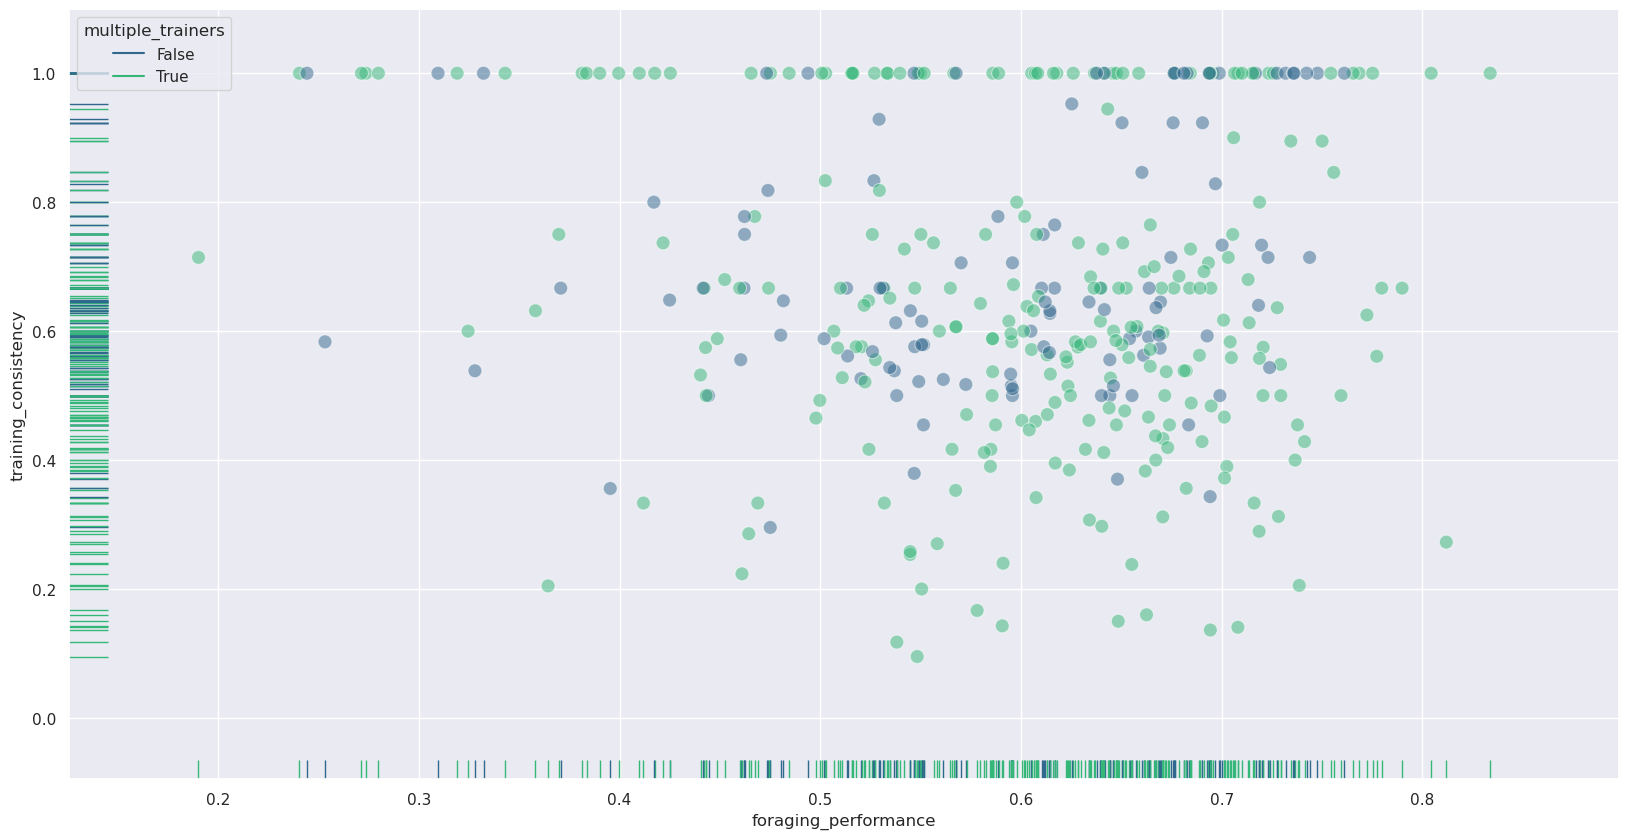

In [157]:
# Visualize overall relationship 

plt.figure(figsize=(20,10))
sns.scatterplot(data=consistency_df, y='training_consistency', x='foraging_performance', hue='multiple_trainers', palette = 'viridis', s=100, alpha=0.5)
sns.rugplot(data=consistency_df, y='training_consistency', x='foraging_performance', hue='multiple_trainers', palette = 'viridis', clip_on=True)

<Figure size 2000x600 with 0 Axes>

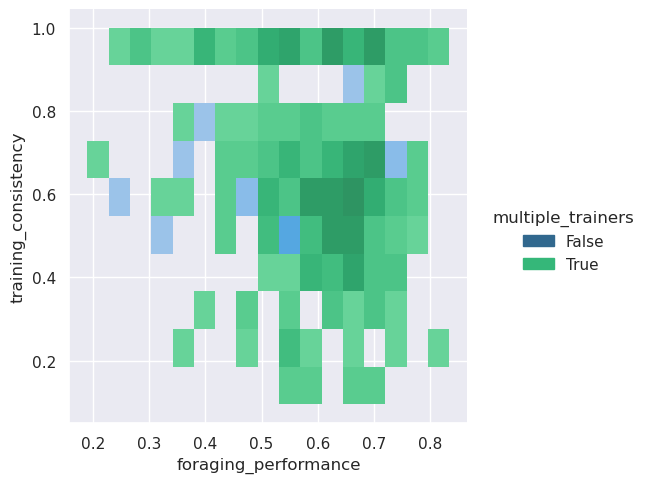

In [158]:
# Visualize distribution / density 

plt.figure(figsize=(20,6))
sns.displot(data=consistency_df, x='foraging_performance', y='training_consistency', palette='viridis', hue='multiple_trainers')

<Figure size 2000x1000 with 0 Axes>

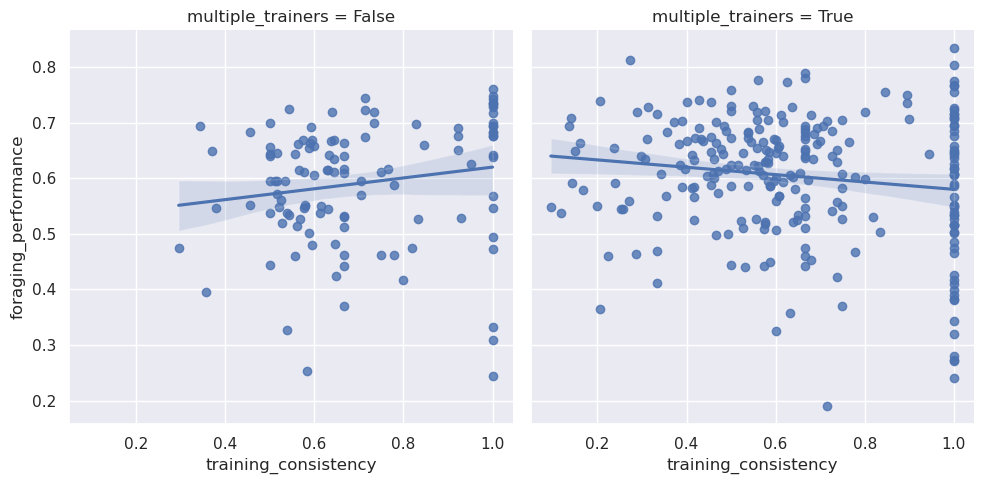

In [159]:

plt.figure(figsize=(20,10))
sns.lmplot(data=consistency_df, x='training_consistency', y='foraging_performance', col='multiple_trainers')

In [160]:
# Create day index and fill missing days with 0 values 

def fill_missing_days(df):
    df['session_date'] = pd.to_datetime(df['session_date'])
    # Sort values
    df = df.sort_values(by=['subject_id', 'session_date'])

    filled_df_list = []

    for subject, group in df.groupby('subject_id'):
        # Calculate the number of days since the first session for each row
        group = group.copy()
        group['day_index'] = (group['session_date'] - group['session_date'].min()).dt.days

        # Create df that spans the entire date range from min to max day_index
        full_day_range = pd.DataFrame({
            'day_index': np.arange(group['day_index'].min(), group['day_index'].max() + 1)
        })

        # Merge with the original group, filling missing days with NaN for performance
        full_group = full_day_range.merge(group, on='day_index', how='left')

        # Fill missing performance values with 0 / fill in all other columns
        full_group['foraging_performance'].fillna(0, inplace=True)
        full_group['subject_id'] = subject
        full_group['user_name'] = group['user_name'].iloc[0]
        full_group['curriculum_name'] = group['curriculum_name'].iloc[0]
        full_group['session_date'] = pd.date_range(start=group['session_date'].min(), periods=len(full_group))

        filled_df_list.append(full_group)

    # Concatenate all the filled dfs
    filled_df = pd.concat(filled_df_list, ignore_index=True)

    return filled_df

In [161]:
select_df = fill_missing_days(select_df)
df = fill_missing_days(df)

print(df.shape)
print(select_df.shape)

/tmp/ipykernel_1412/3630901372.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['session_date'] = pd.to_datetime(df['session_date'])


(9012, 6)
(878, 6)


In [162]:
# Create pivot tables / dfs for average foraging performance with dims: (subject x time)

df_pt = df.pivot_table(
    values='foraging_performance', 
    index='subject_id', 
    columns='day_index',
    aggfunc='mean',
    fill_value=0
)


select_df_pt = select_df.pivot_table(
    values='foraging_performance', 
    index='subject_id', 
    columns='day_index',
    aggfunc='mean',
    fill_value=0
)

df = pd.DataFrame(df_pt.values, index=df_pt.index, columns=df_pt.columns)
select_df = pd.DataFrame(select_df_pt.values, index=select_df_pt.index, columns=select_df_pt.columns)

In [163]:
# Control for unique values in select df

other_users_subjects = main_df[main_df['user_name'] != user]['subject_id'].unique()

select_df['trained_by_others'] = select_df.index.isin(other_users_subjects)

select_df = select_df[select_df['trained_by_others'] == False]

select_df.head()

day_index,0,1,2,3,4,5,6,7,8,9,...,73,74,75,76,77,78,79,80,81,trained_by_others
subject_id,,,,,,,,,,,,,,,,,,,,,
690484,0.11,0.70,0.55,0.47,0.53,0.00,0.00,0.65,0.58,0.52,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,False
690486,0.21,0.55,0.00,0.00,0.73,0.00,0.00,0.75,0.65,0.61,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,False
690494,0.00,0.45,0.27,0.00,0.26,0.00,0.00,0.19,0.50,0.53,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,False
690496,0.35,0.63,0.69,0.61,0.62,0.00,0.00,0.76,0.00,0.73,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,False
705596,0.52,0.00,0.57,0.59,0.34,0.00,0.00,0.43,0.00,0.67,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,False


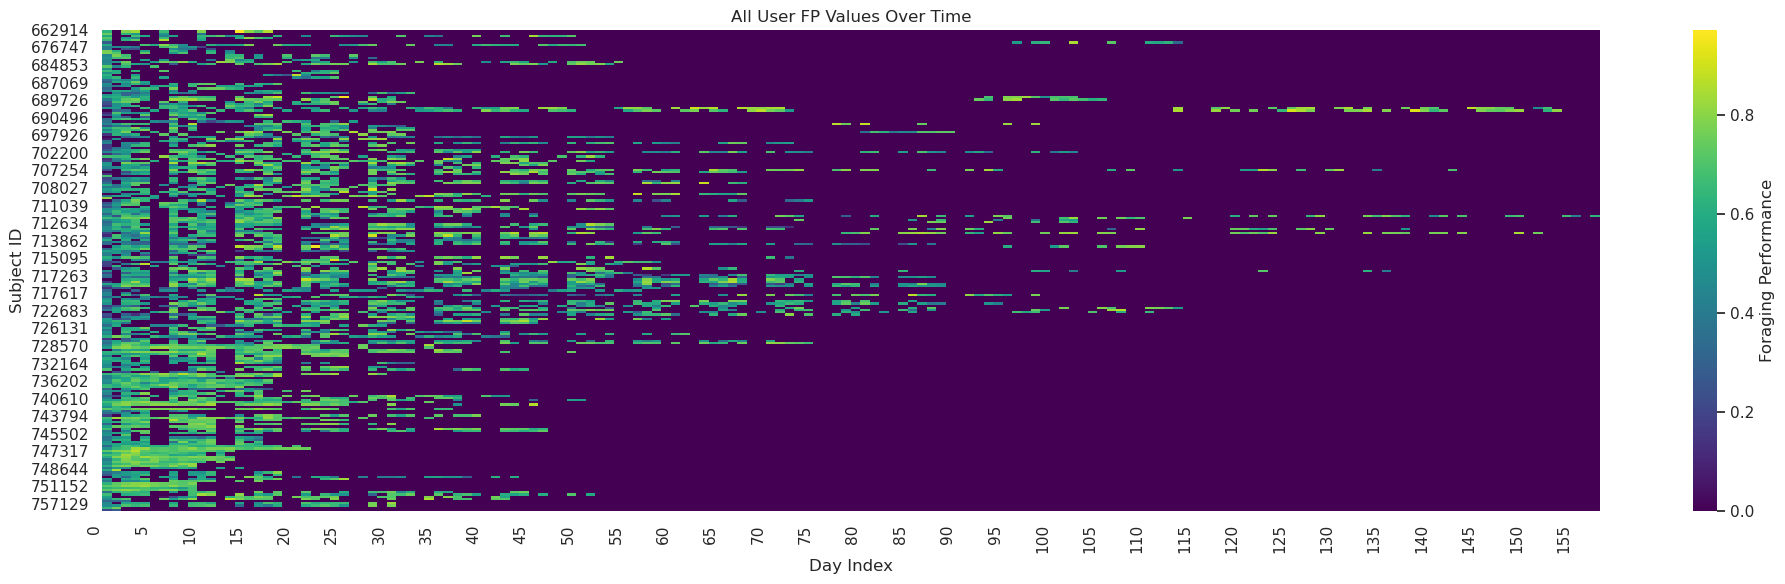

In [164]:
# Plot foraging performance heatmap for all users
sns.cubehelix_palette(as_cmap=True)

plt.figure(figsize=(20,6))
sns.heatmap(data=df, cmap='viridis', cbar_kws={'label': 'Foraging Performance'})

n = df.shape[1]
step=5
tick_positions = np.arange(0, n, step)
tick_labels = df.columns[::step]

plt.xticks(tick_positions, tick_labels, rotation=90, ha='right')
plt.title('All User FP Values Over Time')
plt.xlabel('Day Index')
plt.ylabel('Subject ID')

plt.tight_layout()
plt.show()

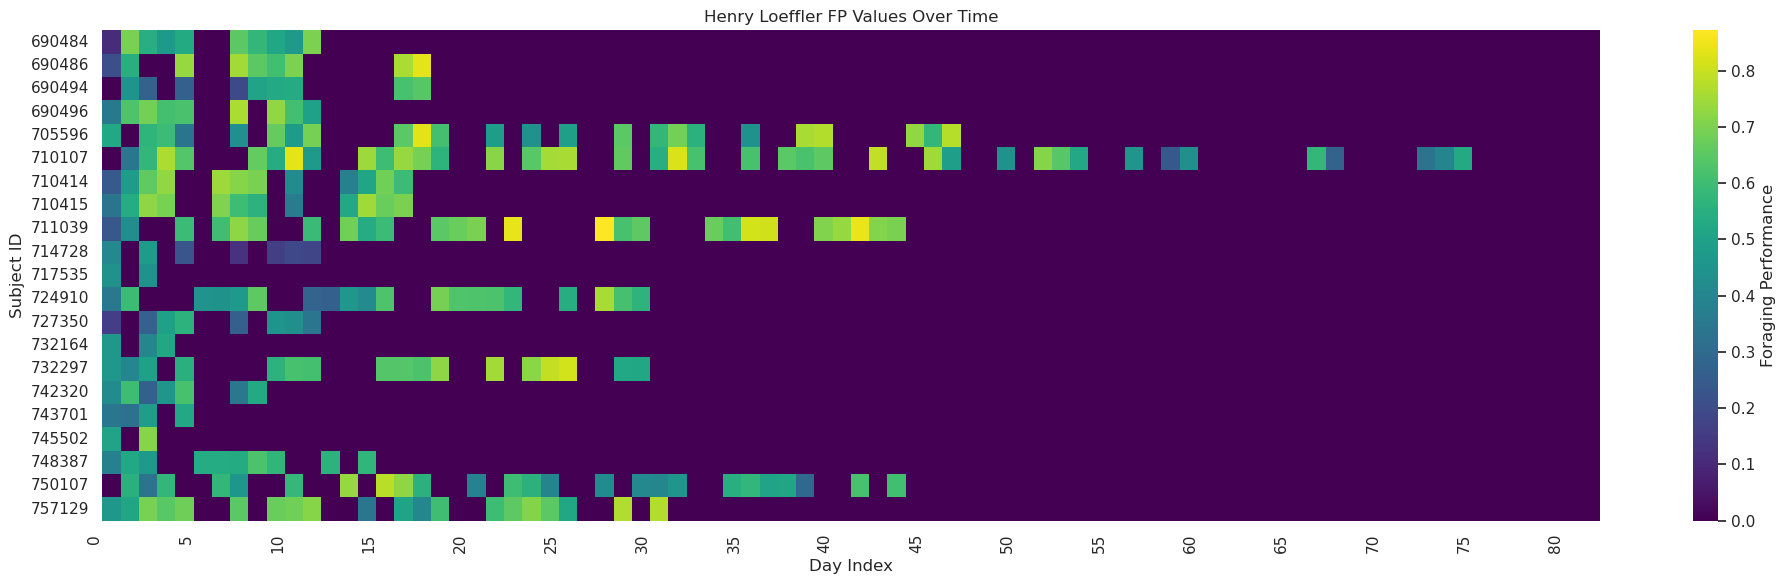

In [165]:
# Plot foraging performance heatmap for select user

# Exclude train_by_others column 
select_df = select_df.drop(columns='trained_by_others')

plt.figure(figsize=(20,6))
sns.heatmap(data=select_df, cmap='viridis', cbar_kws={'label': 'Foraging Performance'})

n = select_df.shape[1]
step=5
tick_positions = np.arange(0, n, step)
tick_labels = select_df.columns[::step]

plt.xticks(tick_positions, tick_labels, rotation=90, ha='right')
plt.title(f'{user} FP Values Over Time')
plt.xlabel('Day Index')
plt.ylabel('Subject ID')

plt.tight_layout()
plt.show()

In [166]:
def analyze_subject(row):

    # Find non-zero values and idxs
    non_zero = row[row != 0]
    non_zero_idx = np.where(row != 0)[0]

    if len(non_zero) <= 1:
        return {'subject_id': row.name, 'continuous': True, 'breaks': 0, 'break_length': []}
    
    # Find gaps between breaks 
    gaps = np.diff(non_zero_idx)

    # If all gaps = 1, then continuous else
    if np.all(gaps == 1):
        return {'subject_id': row.name, 'continuous': True, 'breaks': 0, 'break_length': []}

    # Count gaps and lengths 
    breaks = np.sum(gaps > 1)
    break_length = gaps[gaps > 1] - 1

    return {
        'subject_id': row.name,
        'continuous': False,
        'breaks': breaks,
        'break_length': break_length.tolist()
    }

In [167]:
# For all users

results = df.apply(analyze_subject, axis=1)

results_df = pd.DataFrame(results.tolist())

continuous_subjects = results_df[results_df['continuous']]['subject_id'].tolist()
discontinuous_subjects = results_df[~results_df['continuous']]

print("Subjects with continuous foraging performance:")
print(continuous_subjects)
print("\nSubjects with breaks in foraging performance:")
for _, row in discontinuous_subjects.iterrows():
    print(f"Subject {row['subject_id']}:")
    print(f"  Number of breaks: {row['breaks']}")
    print(f"  Break lengths: {row['break_length']}")
    print()

Subjects with continuous foraging performance:
[684874, 685983, 686868, 689329, 699979, 707524, 736199, 736201, 736202, 736203, 736205, 741212, 747315, 747316, 747320, 747886, 747890, 747893, 748644, 751147, 751151, 751152, 751153, 754375, 764769, 764787]

Subjects with breaks in foraging performance:
Subject 662914:
  Number of breaks: 4
  Break lengths: [1, 2, 3, 3]

Subject 663612:
  Number of breaks: 3
  Break lengths: [1, 2, 3]

Subject 668463:
  Number of breaks: 11
  Break lengths: [2, 1, 2, 3, 2, 2, 3, 2, 3, 2, 2]

Subject 668546:
  Number of breaks: 4
  Break lengths: [1, 2, 3, 3]

Subject 668548:
  Number of breaks: 3
  Break lengths: [1, 2, 3]

Subject 668551:
  Number of breaks: 5
  Break lengths: [95, 1, 2, 3, 3]

Subject 671087:
  Number of breaks: 8
  Break lengths: [3, 2, 2, 3, 3, 2, 2, 2]

Subject 676746:
  Number of breaks: 1
  Break lengths: [2]

Subject 676747:
  Number of breaks: 3
  Break lengths: [1, 3, 1]

Subject 680396:
  Number of breaks: 4
  Break lengths: [

In [168]:
# For selected user

select_results = select_df.apply(analyze_subject, axis=1)

select_results_df = pd.DataFrame(select_results.tolist())

continuous_subjects = select_results_df[select_results_df['continuous']]['subject_id'].tolist()
discontinuous_subjects = select_results_df[~select_results_df['continuous']]

print("Subjects with continuous foraging performance:")
print(continuous_subjects)
print("\nSubjects with breaks in foraging performance:")
for _, row in discontinuous_subjects.iterrows():
    print(f"Subject {row['subject_id']}:")
    print(f"  Number of breaks: {row['breaks']}")
    print(f"  Break lengths: {row['break_length']}")
    print()

Subjects with continuous foraging performance:
[]

Subjects with breaks in foraging performance:
Subject 690484:
  Number of breaks: 1
  Break lengths: [2]

Subject 690486:
  Number of breaks: 3
  Break lengths: [2, 2, 5]

Subject 690494:
  Number of breaks: 3
  Break lengths: [1, 2, 5]

Subject 690496:
  Number of breaks: 2
  Break lengths: [2, 1]

Subject 705596:
  Number of breaks: 12
  Break lengths: [1, 2, 1, 4, 2, 1, 1, 2, 1, 2, 2, 4]

Subject 710107:
  Number of breaks: 16
  Break lengths: [3, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 6, 4]

Subject 710414:
  Number of breaks: 3
  Break lengths: [2, 1, 2]

Subject 710415:
  Number of breaks: 3
  Break lengths: [2, 1, 2]

Subject 711039:
  Number of breaks: 9
  Break lengths: [2, 1, 2, 1, 2, 1, 4, 3, 2]

Subject 714728:
  Number of breaks: 4
  Break lengths: [1, 1, 2, 1]

Subject 717535:
  Number of breaks: 1
  Break lengths: [1]

Subject 724910:
  Number of breaks: 5
  Break lengths: [3, 2, 2, 2, 1]

Subject 727350:
  Number of bre

In [169]:
def performance_difference(row):
    # Get the non-zero values and corrosponding idxs
    non_zero = row[row != 0]
    non_zero_idx = np.where(row != 0)[0]

    # If there are no or only one non-zero value, no breaks exist
    if len(non_zero_idx) <= 1:
        return {
            'subject_id': row.name,
            'mean_performance_difference': 0,
            'absolute_performance_difference': 0,
            'num_breaks': 0,
            'average_break_length': 0
        }

    # Find the idxs where there are gaps
    breaks = np.where(np.diff(non_zero_idx) > 1)[0]
    
    # If no gaps found, return the default values
    if len(breaks) == 0:
        return {
            'subject_id': row.name,
            'mean_performance_difference': 0,
            'absolute_performance_difference': 0,
            'num_breaks': 0,
            'average_break_length': 0
        }

    differences = []
    break_lengths = []
    
    for i in range(len(breaks)):
        # Calculate the fp differences before and after the gap
        last_value_before = non_zero.iloc[breaks[i]]
        first_value_after = non_zero.iloc[breaks[i] + 1]
        
        # - differences = decrease in learning
        # + differences = increase in learning
        differences.append(first_value_after - last_value_before)

        # Calculate length of the gap
        break_length = non_zero_idx[breaks[i] + 1] - non_zero_idx[breaks[i]] - 1
        break_lengths.append(break_length)

    # mean_difference = average, abs_difference = summed changes regardless of gap length, average_break_length = average gap length for a subject
    mean_difference = sum(differences) / len(differences)
    abs_difference = sum(differences)
    average_break_length = sum(break_lengths) / len(break_lengths)

    return {
        'subject_id': row.name,
        'mean_performance_difference': mean_difference,
        'absolute_performance_difference': abs_difference,
        'num_breaks': len(breaks),
        'average_break_length': average_break_length
    }


In [170]:
# All user results
results1 = df.apply(performance_difference, axis=1)
results_df = pd.DataFrame(results1.tolist())

# Select user results
results2 = select_df.apply(performance_difference, axis=1)
select_results_df = pd.DataFrame(results2.tolist())

In [171]:
# Clean - only show non-zero performance differences/gap amounts
cleaned_df = results_df[(results_df['mean_performance_difference'] != 0) | (results_df['num_breaks'] != 0)]
select_cleaned_df = select_results_df[(select_results_df['mean_performance_difference'] != 0) | (select_results_df['num_breaks'] != 0)]

# Sort
cleaned_df = cleaned_df.sort_values('num_breaks', ascending=False)
select_cleaned_df = select_cleaned_df.sort_values('num_breaks', ascending=False)

# Reset index
cleaned_df.reset_index(drop = True)
select_cleaned_df.reset_index(drop = True)


pd.set_option('display.float_format', '{:.2f}'.format)
print(f'All users: {cleaned_df.to_string(index=False)}')
print(f'Select user: {user}: {select_cleaned_df.to_string(index=False)}')

All users:  subject_id  mean_performance_difference  absolute_performance_difference  num_breaks  average_break_length
     711256                         0.00                             0.11          29                  3.45
     706893                         0.01                             0.19          29                  2.83
     713379                        -0.01                            -0.39          27                  3.19
     689799                         0.01                             0.31          25                  3.52
     689798                         0.01                             0.29          25                  3.60
     713377                        -0.00                            -0.00          24                  3.58
     716870                        -0.00                            -0.01          24                  4.08
     722679                         0.01                             0.24          24                  3.04
     722683      

<Axes: xlabel='average_break_length', ylabel='mean_performance_difference'>

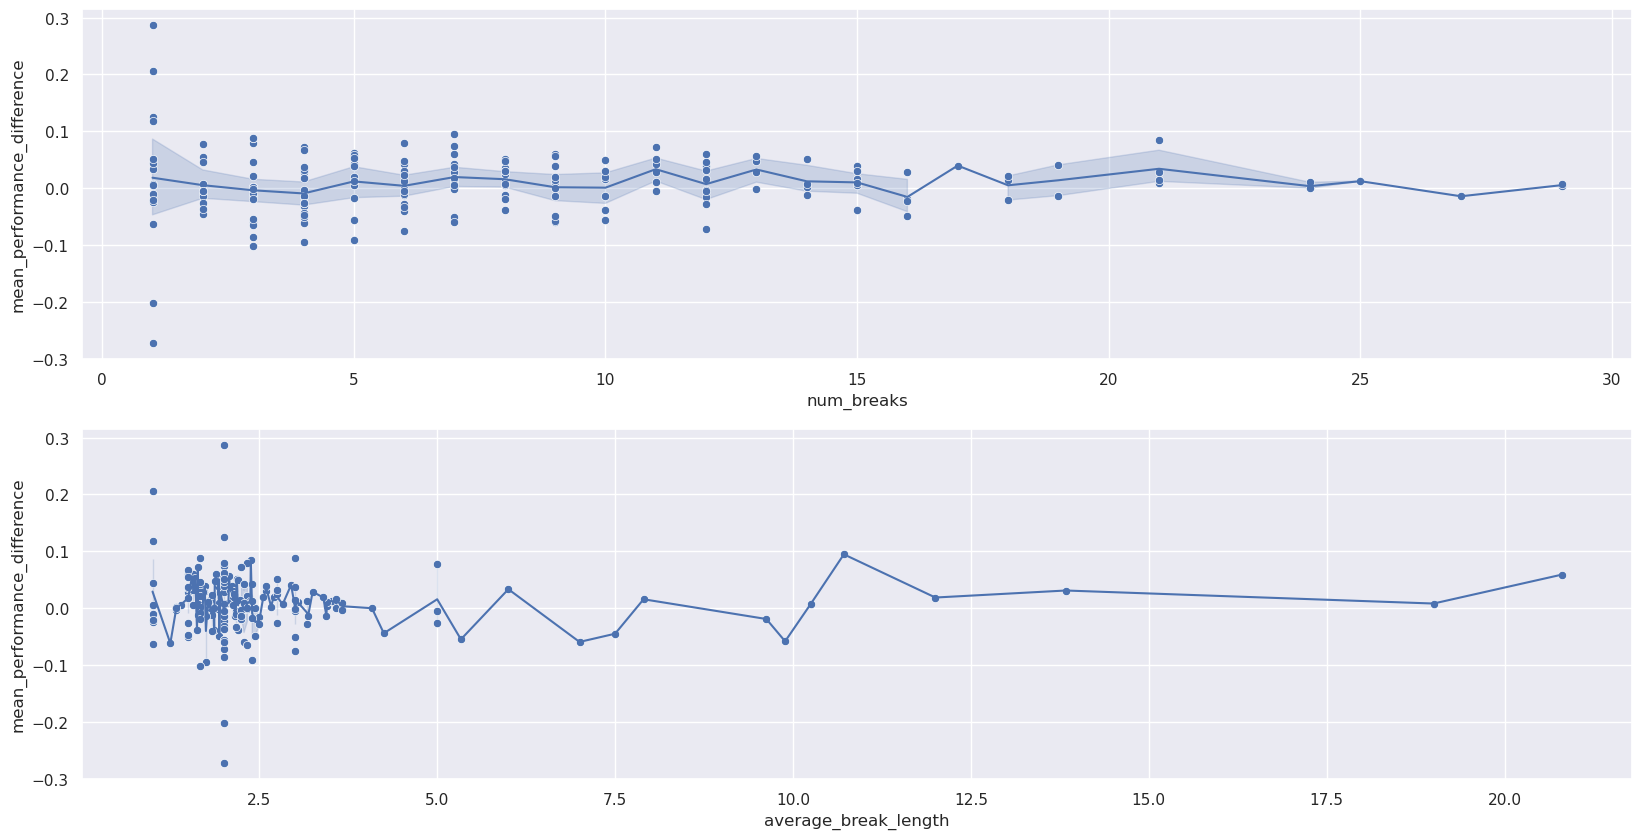

In [172]:
# Plots for all users

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))

sns.lineplot(cleaned_df, x='num_breaks', y='mean_performance_difference', ax=ax1)
sns.scatterplot(cleaned_df, x='num_breaks', y='mean_performance_difference', ax=ax1)

sns.lineplot(cleaned_df, x='average_break_length', y='mean_performance_difference', ax=ax2)
sns.scatterplot(cleaned_df, x='average_break_length', y='mean_performance_difference', ax=ax2)

<Axes: xlabel='num_breaks', ylabel='mean_performance_difference'>

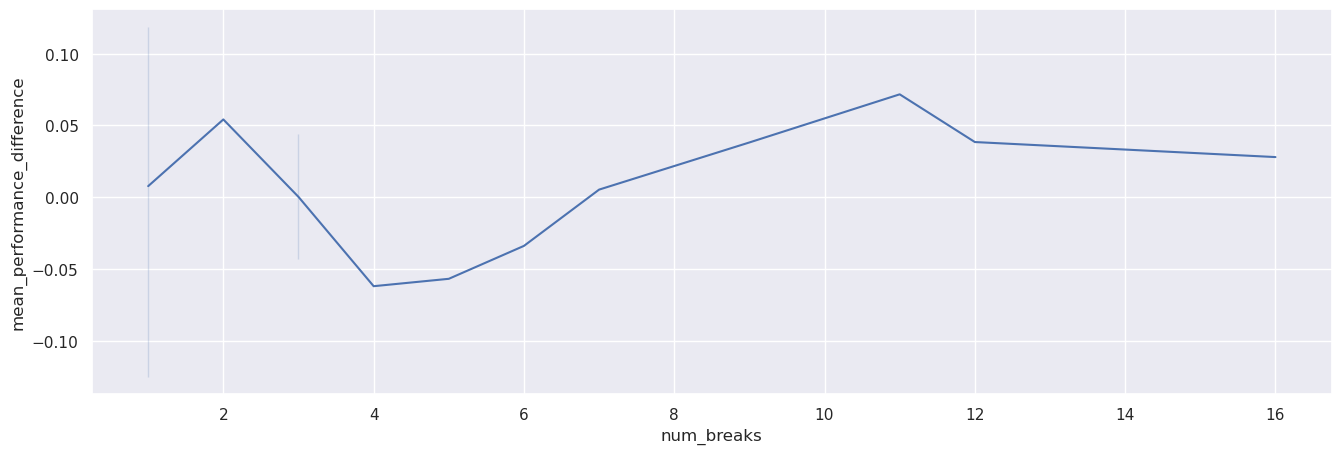

In [173]:
# Plot of selected user 

plt.figure(figsize=(16,5))

sns.lineplot(select_cleaned_df, x='num_breaks', y='mean_performance_difference')

In [174]:
testing_df = consistency_df.merge(cleaned_df[['subject_id', 'mean_performance_difference', 'num_breaks', 'average_break_length']], on='subject_id', how='left')

testing_df

,subject_id,user_name,date_range,training_days,training_consistency,foraging_performance,multiple_trainers,mean_performance_difference,num_breaks,average_break_length
0,662914,Ella Hilton,4,4,1.00,0.83,True,0.07,4.00,2.25
1,662914,Katrina Nguyen,11,5,0.45,0.74,True,0.07,4.00,2.25
2,663612,Katrina Nguyen,11,5,0.45,0.55,False,-0.09,3.00,2.00
3,668463,Lucas Kinsey,50,23,0.46,0.61,True,0.05,11.00,2.18
4,668463,Travis Ramirez,5,3,0.60,0.51,True,0.05,11.00,2.18
...,...,...,...,...,...,...,...,...,...,...
365,757128,Ella Hilton,26,17,0.65,0.61,True,0.03,8.00,1.50
366,757128,margaret lee,3,2,0.67,0.79,True,0.03,8.00,1.50
367,757129,Henry Loeffler,31,20,0.65,0.61,False,0.01,7.00,1.57
368,764769,Avalon Amaya,2,2,1.00,0.69,False,NaN,NaN,NaN


<Axes: xlabel='average_break_length', ylabel='training_consistency'>

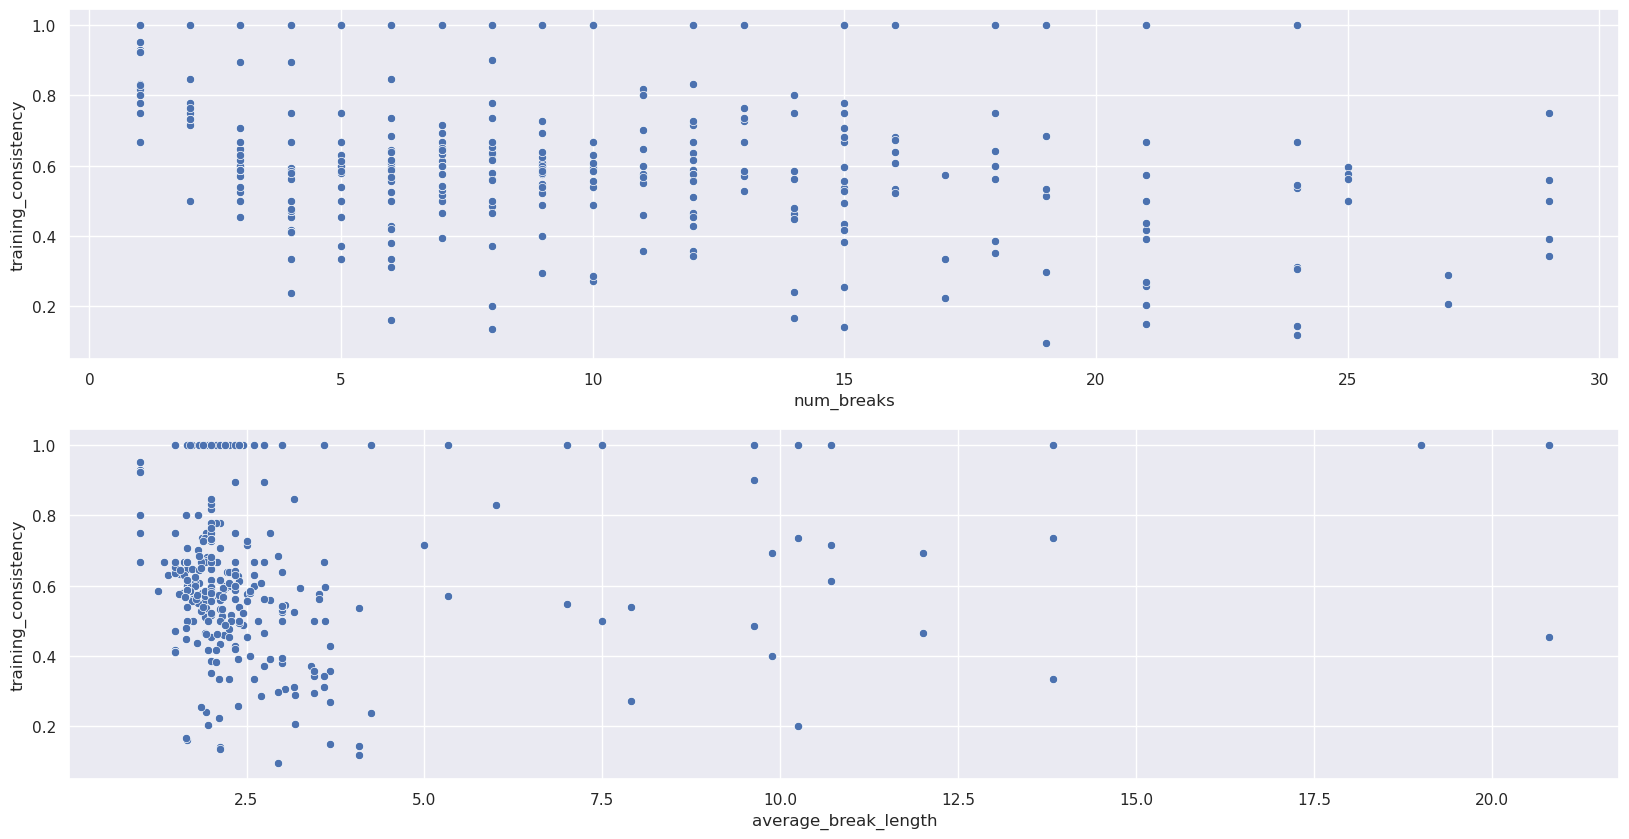

In [175]:
# Plots for all users

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))

sns.scatterplot(testing_df, x='num_breaks', y='training_consistency', ax=ax1)

sns.scatterplot(testing_df, x='average_break_length', y='training_consistency', ax=ax2)